# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
### Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from pylab import rcParams
import tensorflow as tf
import pickle
import time
import os
import cv2
import csv
from PIL import Image
%matplotlib inline

In [2]:
### Load pickled data

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Basic data summary.

# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# What's the shape of an image?
image_shape = X_train[0].shape

# How many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

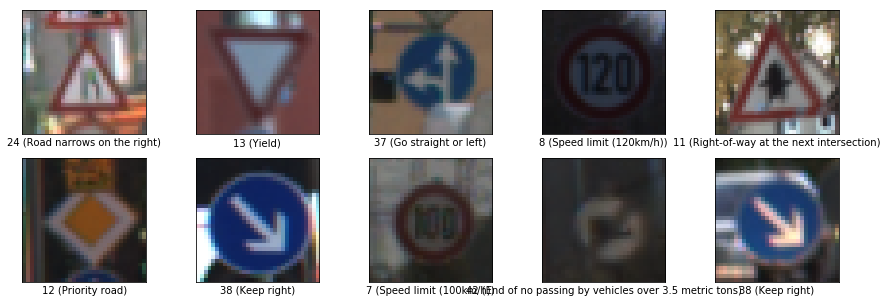

In [4]:
### Data exploration visualization
fig = plt.figure(figsize=(15, 5))

image_seq = np.random.randint(1,len(X_train),10)

# Load image labels from csv
label_csv = csv.reader(open('signnames.csv', 'r'))
label_names = []
for row in label_csv:
    label_names.append(row[1])
label_names.pop(0)

for ind,val in enumerate(image_seq):
    img = fig.add_subplot(2,5,ind+1)
    plt.imshow(X_train[val-1])
    #Add corresponding label
    img.set_xlabel("{0} ({1})".format(y_train[val-1], label_names[y_train[val-1]]))
    #Remove the axis ticks
    img.set_xticks([])
    img.set_yticks([])

plt.show()

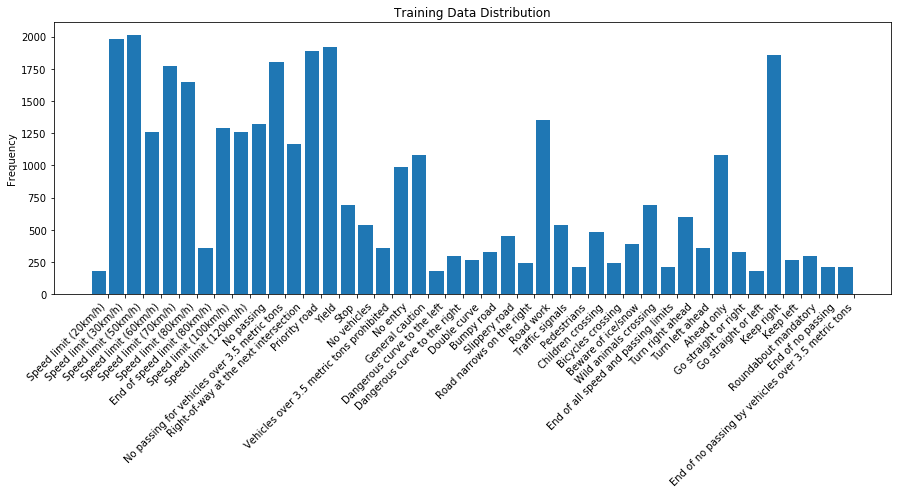

In [5]:
### Plot dataset distribution
unique, counts = np.unique(y_train, return_counts=True)
fig = plt.figure(figsize=(15,5))
plt.bar(unique, counts)

label = [label for label in label_names]

plt.xticks(np.arange(0.5,n_classes+0.5), label, rotation=45,ha='right')

plt.ylabel('Frequency')
plt.title('Training Data Distribution')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
'''
# Grayscale conversion

#Weighted average approach utilizing numpy functions. No need for OpenCV
#Y' = 0.299 R + 0.587 G + 0.114 B 

X_train_gray = np.dot(X_train[...][...,:3],[0.299,0.587,0.114])
X_test_gray = np.dot(X_test[...][...,:3],[0.299,0.587,0.114])
'''

# Variable names defined for convenience
X_train_gray = X_train
X_valid_gray = X_valid
X_test_gray = X_test

# Normalize data (Zero-Mean)
X_train_gray_norm = (X_train_gray - np.mean(X_train_gray))/np.std(X_train_gray)
X_valid_gray_norm = (X_valid_gray - np.mean(X_valid_gray))/np.std(X_valid_gray)
X_test_gray_norm = (X_test_gray - np.mean(X_test_gray))/np.std(X_test_gray)

In [7]:
### One-Hot Encoding
'''
Since we already have the labels we can use Label Binarizer.
'''
encoder = preprocessing.LabelBinarizer()
y_train_oh = encoder.fit_transform(y_train)
y_valid_oh = encoder.fit_transform(y_valid)
y_test_oh = encoder.fit_transform(y_test)

In [8]:
### Shuffle data

train_features, train_labels = shuffle(X_train_gray_norm, y_train_oh)
valid_features, valid_labels = shuffle(X_valid_gray_norm, y_valid_oh)

In [9]:
# Flatten/Reshape data
image_size = len(train_features[0])
n_input = image_size**2
num_channels = 3

train_features_f = np.reshape(train_features, [-1, image_size, image_size, num_channels])
valid_features_f = np.reshape(valid_features, [-1, image_size, image_size, num_channels])
X_test_gray_flat = np.reshape(X_test_gray_norm, [-1, image_size, image_size, num_channels])

### Model Architecture

In [10]:
### Helper Functions
def calc_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.01))


def calc_biases(length):
    return tf.Variable(tf.zeros(length))


def maxpool(ip, stride_len = 2):
    filter_size = [1, stride_len, stride_len, 1]
    return tf.nn.max_pool(ip, ksize = filter_size, strides = [1, stride_len, stride_len, 1], padding = 'VALID')

def dropout(layer, dropout_prob):
    return tf.nn.dropout(layer, dropout_prob)


def conv_layer(ip, weights, biases, stride_len = 1):
    '''
    input_layer_width -> Number of inputs from previous layer
    output_layer_width -> width of layer
    '''  
    c_layer = tf.nn.conv2d(ip, weights, strides = [1, stride_len, stride_len, 1], padding = 'VALID')
    c_layer = tf.nn.bias_add(c_layer, biases)
    
    c_layer = maxpool(c_layer, 2) #stride length for max_pool = 2
    
    c_layer = tf.nn.relu(c_layer)
    return c_layer


def reshape_layer(ip):
    '''
    Flatten or reshape conv_layer for input to fc_layer
    '''
    flat_layer = tf.reshape(ip, [-1, ip.get_shape()[1:4].num_elements()])
    
    #print("Flat Layer: %s" %flat_layer.get_shape())
    
    return flat_layer

def fully_conn_layer(ip, weights, biases):
    '''
    input_layer_width -> Number of inputs from previous flattened layer
    output_layer_width -> width of layer, or equal to number of classes for prediction layer
    '''  
    flat_input = reshape_layer(ip)
    fc_layer = tf.add(tf.matmul(flat_input, weights), biases)
    
    #print("FC Layer: %s" %fc_layer.get_shape())
    
    #Not applying ReLU here because this could be prediction layer
    return fc_layer

def plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cls_pred):
    test_cls = np.argmax(y_test_oh, axis=1)
    cm = confusion_matrix(y_true=test_cls,
                              y_pred=cls_pred)

    # Print the confusion matrix as text.
    #print(cm)
    
    rcParams['figure.figsize'] = 13,13
    
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def print_test_accuracy():
    test_cls = np.argmax(y_test_oh, axis=1)
    cls_pred = np.zeros(shape=n_test, dtype=np.int)
    i = 0

    while i < n_test:
        j = min(i + batch_size, n_test)

        batch_x = X_test_gray_flat[i:j]
        batch_y = y_test_oh[i:j]
        
        feed_dict={network_input: batch_x, network_output: batch_y, keep_prob: 1.0}

        cls_pred[i:j] = session.run(label_pred_class, feed_dict=feed_dict)

        i = j
    
    correct = (test_cls == cls_pred)
    correct_sum = correct.sum()

    acc = float(correct_sum) / n_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, n_test))

    plot_confusion_matrix(cls_pred=cls_pred)


In [11]:
### Convnet model
def convnet_model(ip, weights_dict, biases_dict, dropout_prob):
    
    #First conv layer
    c_layer_1 = conv_layer(ip, weights_dict['layer_1'], biases_dict['layer_1'], stride_len = 1)
    c_layer_1 = dropout(c_layer_1, dropout_prob)
    
    #Second conv layer
    c_layer_2 = conv_layer(c_layer_1, weights_dict['layer_2'], biases_dict['layer_2'], stride_len = 1)
    c_layer_2 = dropout(c_layer_2, dropout_prob)
    
    #FC Layer
    fc_layer = fully_conn_layer(c_layer_2, weights_dict['fc_layer'], biases_dict['fc_layer'])
    
    fc_layer = tf.nn.relu(fc_layer)
    fc_layer = dropout(fc_layer, dropout_prob)
    
    #Output fc layer
    out = fully_conn_layer(fc_layer, weights_dict['out'], biases_dict['out'])
    
    return out  


In [12]:
# Dimensions
layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'fc_layer': 1024,
    'out': n_classes
} # number of filters

filter_size = {
    'layer_1': 5,
    'layer_2': 5
} # conv filter size


# Weights and biases
weights_dict = {
    'layer_1': calc_weights([filter_size['layer_1'], filter_size['layer_1'] , num_channels, layer_width['layer_1']]),
    'layer_2': calc_weights([filter_size['layer_2'], filter_size['layer_2'] , layer_width['layer_1'], layer_width['layer_2']]),
    'fc_layer': calc_weights([ 1600, layer_width['fc_layer']]),
    'out': calc_weights([layer_width['fc_layer'], layer_width['out']])
}

biases_dict = {
    'layer_1': calc_biases([layer_width['layer_1']]),
    'layer_2': calc_biases([layer_width['layer_2']]),
    'fc_layer': calc_biases([layer_width['fc_layer']]),
    'out': calc_biases([layer_width['out']])
}

In [13]:
# Define Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 64
display_step = 1

In [14]:
# Input graph for TF
network_input = tf.placeholder("float", [None, image_size, image_size, num_channels])
network_output = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

logits = convnet_model(network_input, weights_dict, biases_dict, keep_prob)

label_pred = tf.nn.softmax(logits)
label_pred_class = tf.argmax(label_pred, 1)

# Cost function and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, network_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Check if predictions are correct.
correct_prediction = tf.equal(label_pred_class, tf.argmax(network_output, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

Epoch: 0001 cost= 1.451362882
Time after epoch: 22.982332468032837
Epoch: 0002 cost= 0.401647288
Time after epoch: 21.27262544631958
Epoch: 0003 cost= 0.281404501
Time after epoch: 21.228514909744263
Epoch: 0004 cost= 0.223528586
Time after epoch: 21.24545454978943
Epoch: 0005 cost= 0.205757052
Time after epoch: 21.35507559776306
Epoch: 0006 cost= 0.181700410
Time after epoch: 21.29146385192871
Epoch: 0007 cost= 0.177329833
Time after epoch: 21.226741313934326
Epoch: 0008 cost= 0.167359911
Time after epoch: 21.319254159927368
Epoch: 0009 cost= 0.155487567
Time after epoch: 21.222962379455566
Epoch: 0010 cost= 0.151694759
Time after epoch: 21.275651931762695
Epoch: 0011 cost= 0.154144610
Time after epoch: 21.26738715171814
Epoch: 0012 cost= 0.139211024
Time after epoch: 21.29677700996399
Epoch: 0013 cost= 0.147966928
Time after epoch: 21.25041675567627
Epoch: 0014 cost= 0.135653796
Time after epoch: 21.260560512542725
Epoch: 0015 cost= 0.143052543
Time after epoch: 21.291926860809326
Ep

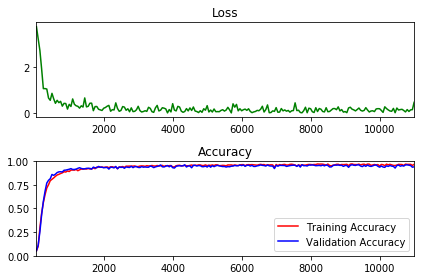

Time taken: 434.5146470069885


In [15]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well..

# Initialize variables
init = tf.global_variables_initializer()
#init = tf.initialize_all_variables()

batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

total_time = time.time()
# Launch graph
session = tf.Session()
session.run(init)
    
# Training cycle
for epochs in range(training_epochs):
    start_time = time.time()
    avg_cost = 0.
    total_batch = int(len(train_features)/batch_size)

    train_features_f, train_labels = shuffle(train_features_f, train_labels)
    valid_features_f, valid_labels = shuffle(valid_features_f, valid_labels)

    for i in range(total_batch):
        idx_l = i*batch_size
        idx_h = idx_l + batch_size

        batch_x = train_features_f[idx_l:idx_h]
        batch_y = train_labels[idx_l:idx_h]

        _,c = session.run([optimizer, cost], feed_dict = {network_input: batch_x, network_output: batch_y, keep_prob: 0.5})

        # Compute average loss
        avg_cost += c / total_batch


    # Log every 50 batches
        if not i % 50:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict={network_input: train_features_f, 
                                                                 network_output: train_labels, keep_prob: 0.5 })
            validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, 
                                                                   network_output: valid_labels, keep_prob: 1})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(50 + previous_batch)
            loss_batch.append(c)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)


    # Display logs per epoch step
    if epochs % display_step == 0:
        print("Epoch:", '%04d' % (epochs+1), "cost=", \
            "{:.9f}".format(avg_cost))
    end_time = time.time() - start_time
    print("Time after epoch: %s" %end_time)

    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, 
                                                           network_output: valid_labels, keep_prob: 1})

print("Optimization Finished!")

test_accuracy = session.run(accuracy, feed_dict = 
                                        {network_input: X_test_gray_flat, network_output: y_test_oh, keep_prob: 1})
print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch)

final_time = time.time() - total_time
print("Time taken: %s" %final_time)

Accuracy on Test-Set: 94.8% (11976 / 12630)


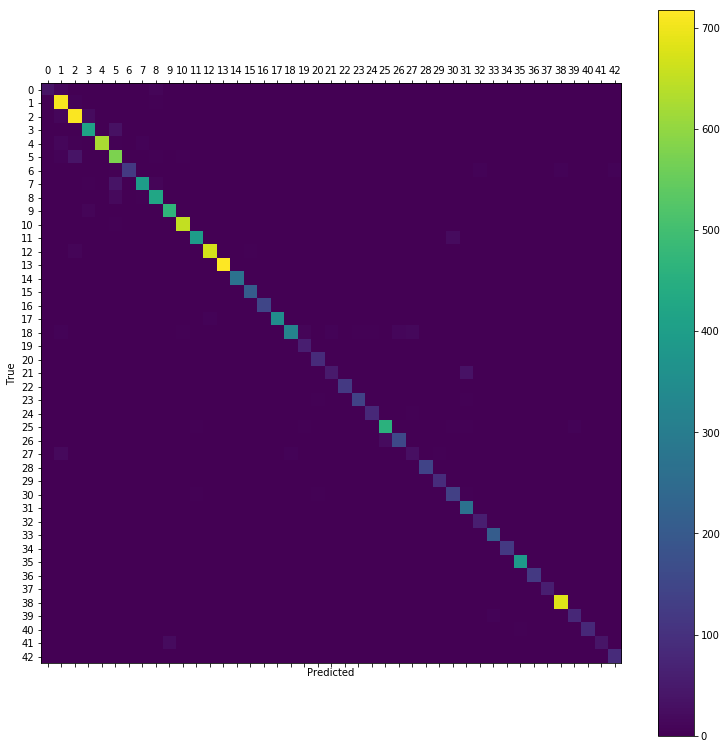

In [16]:
#Confusion Matrix
print_test_accuracy()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

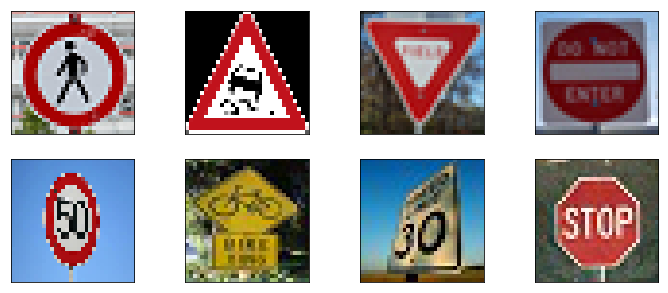

In [17]:
### Load the images and plot them here.

images = os.listdir("test_images/")

fig = plt.figure(figsize=(12, 5))

test_images = []

# Read in test images
for idx,val in enumerate(images):
    #reading in an image
    image = cv2.imread('test_images/' + images[idx])
    if len(image.shape) > 2 and image.shape[2] == 4:
        #convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if image.shape[0] != 32:
        
        image = cv2.resize(image, (32, 32))
    test_images.append(image)


# Create subplots in figure
for r in range(1,len(test_images)+1):
    img = fig.add_subplot(2,4,r)
    plt.imshow(test_images[r-1])
    img.set_xticks([])
    img.set_yticks([])

plt.show()

In [18]:
### Preprocess images
# The images are already 32x32

# Normalize data (Zero-Mean)
test_images_norm = (test_images - np.mean(test_images))/np.std(test_images)

# Reshape
test_images_norm_f = np.reshape(test_images_norm, [-1, image_size, image_size, num_channels])
print(test_images_norm_f.shape)

# Define True Labels
y_new_true = np.array([27, 23, 13, 17, 2, 29, 1, 14])
# Convert to One Hot Encoded Values
y_new_true_one_hot = (np.arange(n_classes) == y_new_true[:,None]).astype(np.float)

(8, 32, 32, 3)


### Predict the Sign Type for Each Image

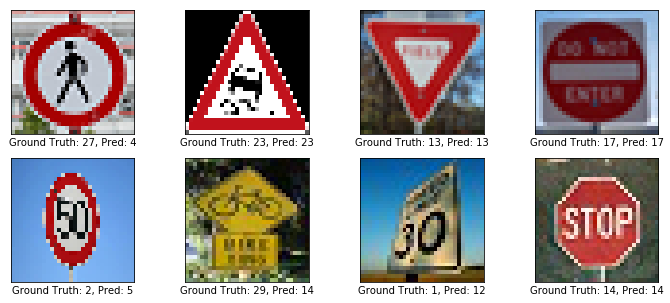

In [19]:
### Run the predictions here and use the model to output the prediction for each image.
new_predictions = session.run(label_pred, feed_dict = {network_input: test_images_norm_f, network_output:y_new_true_one_hot , keep_prob: 1.0})
new_label_list = [np.argmax(row) for row in new_predictions]

fig = plt.figure(figsize=(12,5))
# Create subplots in figure
for r in range(1,len(test_images)+1):
    img = fig.add_subplot(2,4,r)
    plt.imshow(test_images[r-1])
    img.set_xlabel("Ground Truth: {0}, Pred: {1}".format(y_new_true[r-1],new_label_list[r-1]))
    img.set_xticks([])
    img.set_yticks([])

plt.show()

### Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

test_accuracy = (100.0 * np.sum(np.argmax(new_predictions, 1) == np.argmax(y_new_true_one_hot, 1))/ new_predictions.shape[0])

print("Test Accuracy: {0}%".format(test_accuracy))

Test Accuracy: 50.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

for i,val in enumerate(test_images):
    
    # Top 5 probabilities and corresponding classes
    top_5 = tf.nn.top_k(new_predictions[i], k=5)
    indices = top_5.indices.eval(session=session)
    values = top_5.values.eval(session=session)
    
    # Sort in Descending order
    idx = np.argsort(values)[::-1]
    values = values[idx]
    indices = indices[idx]

    # Print probabilities
    print("Image {0}, Top 5 Probabilities: {1}".format(i, [ round(value, 5) for value in values]))

Image 0, Top 5 Probabilities: [0.97455001, 0.025210001, 0.00023999999, 0.0, 0.0]
Image 1, Top 5 Probabilities: [0.99996001, 3.9999999e-05, 0.0, 0.0, 0.0]
Image 2, Top 5 Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0]
Image 3, Top 5 Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0]
Image 4, Top 5 Probabilities: [0.90333998, 0.037769999, 0.033709999, 0.02101, 0.0038000001]
Image 5, Top 5 Probabilities: [0.9874, 0.00416, 0.0040500001, 0.00147, 0.00136]
Image 6, Top 5 Probabilities: [0.85771, 0.14195, 0.00019999999, 9.0000001e-05, 3.9999999e-05]
Image 7, Top 5 Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0]


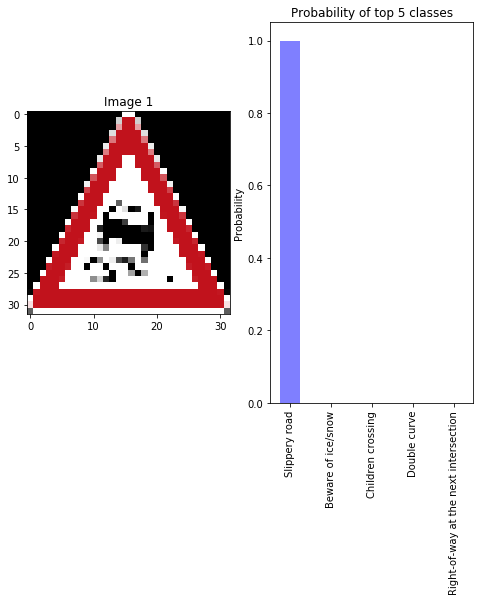

In [22]:
### Plot Softmax Probability for 1 sample image
fig = plt.figure(figsize=(8,7))
# Plot the original image
plt.subplot(1,2,1);
plt.imshow(test_images[1])
plt.title('Image {0}'.format(1));

top_5 = tf.nn.top_k(new_predictions[1], k=5)
indices = top_5.indices.eval(session=session)
values = top_5.values.eval(session=session)

# Sort in Descending order
idx = np.argsort(values)[::-1]
values = values[idx]
indices = indices[idx]

y_pos = range(0, 200, 40)

plt.subplot(1,2,2)
plt.bar(y_pos, values, align='center', alpha=0.5, color='blue', width=20)

plt.xticks(y_pos, [label_names[idx] for idx in indices])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.ylabel('Probability')
plt.title('Probability of top 5 classes')
plt.show()

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 